In [1]:
from mlguess.keras.models import CategoricalDNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from hagelslag.evaluation.ProbabilityMetrics import DistributedReliability
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
import yaml
import glob
import os
from collections import defaultdict
from ptype.plotting import plot_confusion_matrix

2024-07-28 23:33:52.150989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 23:33:53.167715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 23:33:53.167798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-28 23:33:54.034166: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 23:34:20.525370: W te

Set up model

In [1]:
def locate_best_model(filepath, metric="val_ave_acc", direction="max"):
    filepath = glob.glob(os.path.join(filepath, "models", "training_log_*.csv"))
    func = min if direction == "min" else max
    scores = defaultdict(list)
    for filename in filepath:
        f = pd.read_csv(filename)
        best_ensemble = int(filename.split("_log_")[1].strip(".csv"))
        scores["best_ensemble"].append(best_ensemble)
        scores["metric"].append(func(f[metric]))

    best_c = scores["metric"].index(func(scores["metric"]))
    return scores["best_ensemble"][best_c]

In [3]:
# best ML trial:
import yaml
import pandas as pd
from collections import defaultdict
yaml_file = '/glade/derecho/scratch/sreiner/res11/best_trial_val3/model.yml'

with open(yaml_file) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
model = '/glade/derecho/scratch/sreiner/res11/best_trial_val3/models/best.h5'

In [47]:
input_features = []
for features in conf["input_features"]:
    input_features += conf[features]
output_features = conf["output_features"]
n_splits = conf["ensemble"]["n_splits"]
save_loc = conf["save_loc"]
labels = ["rain", "snow", "sleet", "frz-rain"]
sym_colors = ["blue", "grey", "red", "purple"]
symbols = ["s", "o", "v", "^"]

save_loc = conf['save_loc']
best_split = locate_best_model(save_loc, conf["metric"], conf["direction"])

In [48]:
best_split

14

In [49]:
data = {
    name: pd.read_parquet(
        os.path.join(save_loc, "evaluate", f"{name}_{best_split}.parquet")
    )
    for name in ["train", "val", "test"]
}

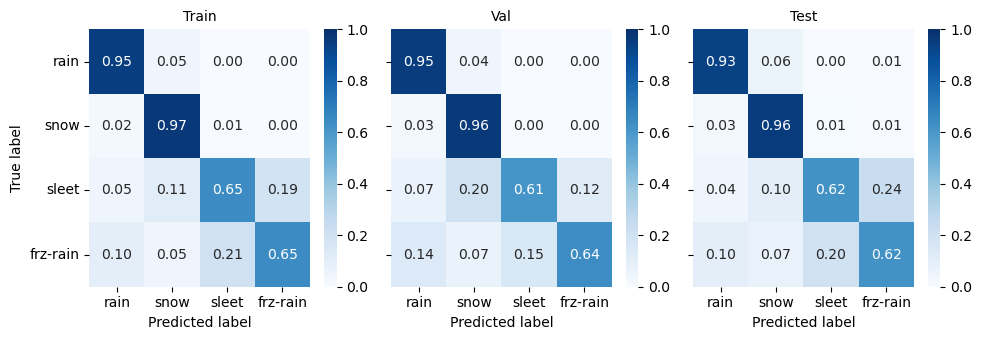

In [50]:
plot_confusion_matrix(
    data,
    labels,
    axis=1,
    normalize=True,
)

In [51]:
plot_data = {
    key: {
        'true_label': ds['true_label'].values,
        'pred_label': ds['pred_label'].values,
        'rap_truth': np.zeros(len(ds)),  # Initialize RAP truth labels
        'rap_precip_mask': (ds[['CRAIN', 'CSNOW', 'CICEP', 'CFRZR']].sum(axis=1) > 0).values  # RAP precipitation mask
    }
    for key, ds in data.items()
}

# Define classes
classes = ['Rain', 'Snow', 'Ice Pellets', 'Freezing Rain']

# Assign RAP truth labels based on conditions
for key, ds in data.items():
    for i, ptype in enumerate(['CRAIN', 'CSNOW', 'CICEP', 'CFRZR']):
        mask = ds[ptype] == 1
        plot_data[key]['rap_truth'][mask] = i


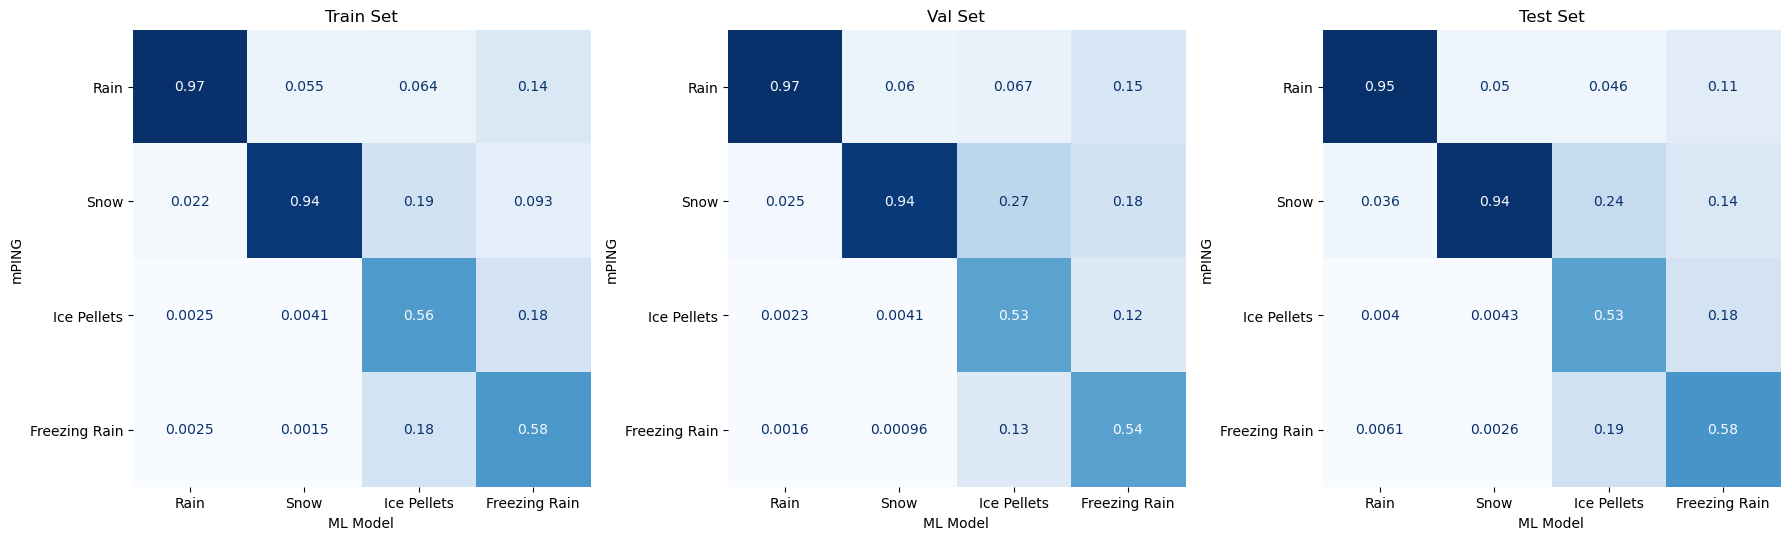

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, (key, ds) in zip(axes, plot_data.items()):
    cm = confusion_matrix(ds['true_label'], ds['pred_label'], normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    ax.set_title(f'{key.title()} Set')
    ax.set_ylabel('mPING')
    ax.set_xlabel('ML Model')
    ax.spines[:].set_visible(False)

    
plt.tight_layout()
plt.show()

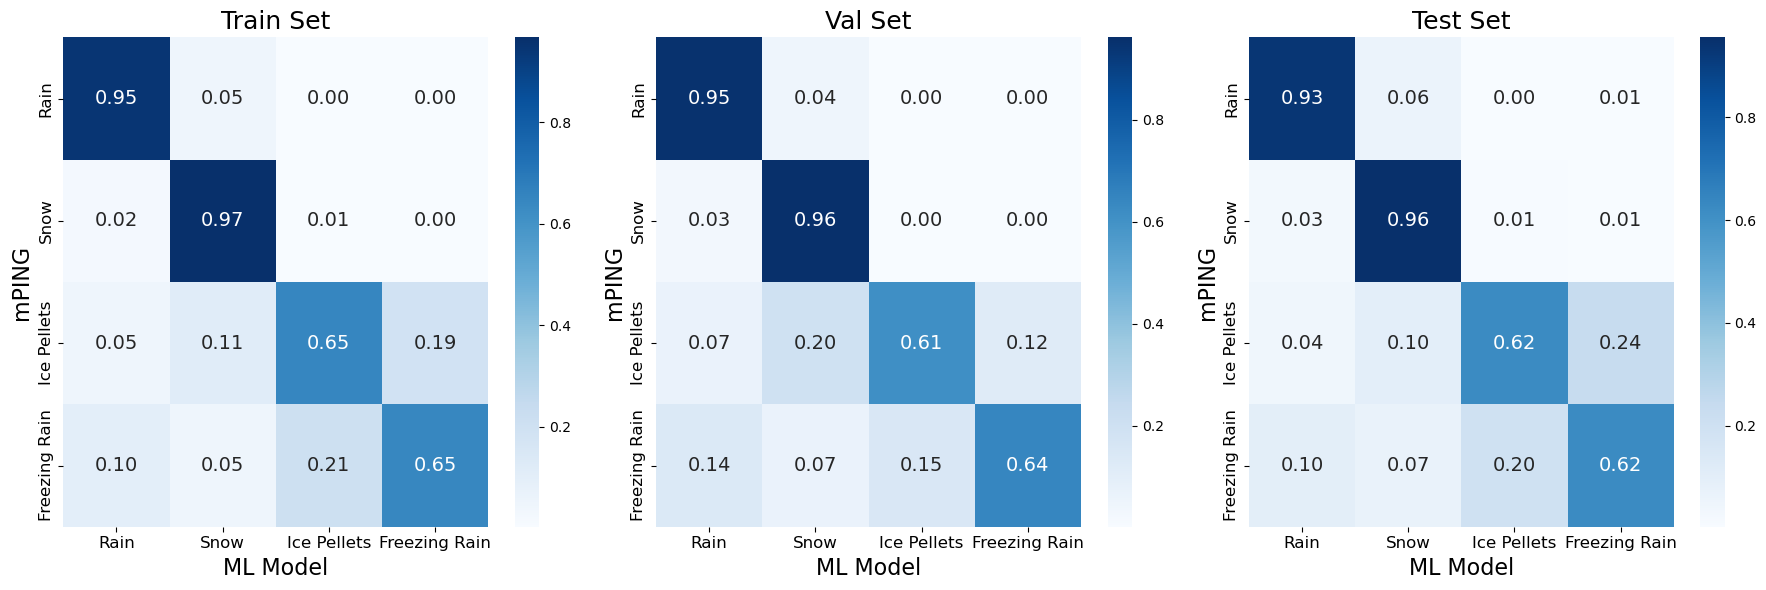

In [52]:
import seaborn as sns
def plot_confusion_matrices(data, classes, cmap):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    plt.rcParams['text.usetex'] = True
    for ax, (key, ds) in zip(axes, data.items()):
        cm = confusion_matrix(ds['true_label'], ds['pred_label'], normalize='true')
        plt.rcParams['text.usetex'] = False
        # Plot confusion matrix using seaborn heatmap
        sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, cbar=True,
                    xticklabels=classes, yticklabels=classes, ax=ax,
                    annot_kws={'size': 14})
        
        ax.set_title(f'{key.title()} Set', fontsize=18)
        ax.set_ylabel('mPING', fontsize=16)
        ax.set_xlabel('ML Model', fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
    plt.tight_layout()
    plt.savefig("./plots/confusion_res13_val3_notex_norm_true.png", dpi=300)

# Plot the confusion matrices
plot_confusion_matrices(plot_data, classes, plt.cm.Blues)

In [16]:
# Function to plot confusion matrices using ConfusionMatrixDisplay
def plot_confusion_matrices(data, classes, figsize=(16, 6), normalize='pred'):
    """
    Function to plot confusion matrices using ConfusionMatrixDisplay.

    data: dictionary, generally has 'train', 'val', and 'test' data
    classes: different p-types to be tested, list
    normalize: normalization mode for confusion matrix, e.g., 'true', 'pred', 'all'
    figsize: size of the plot
    """
    cmap = plt.cm.Blues
    for i, key in enumerate(data.keys()):
        fig, axes = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)

        ds = data[key]
        cm_mping = confusion_matrix(ds['true_label'], ds['pred_label'], normalize=normalize)
        cm_rap = confusion_matrix(ds['rap_truth'][ds['rap_precip_mask']], ds['pred_label'][ds['rap_precip_mask']], normalize=normalize)
        cm_rap_mping = confusion_matrix(ds['rap_truth'][ds['rap_precip_mask']], ds['true_label'][ds['rap_precip_mask']], normalize=normalize)
        
        # mPING vs ML Prediction
        disp_mping = ConfusionMatrixDisplay(confusion_matrix=cm_mping, display_labels=classes)
        disp_mping.plot(ax=axes[0], colorbar=False, cmap=cmap)
        axes[0].set_title(f'{key.title()} mPING vs ML', fontsize=18)
        axes[0].set_ylabel('mPING', fontsize=14)
        axes[0].set_xlabel('ML Prediction', fontsize=14)
        
        # RAP vs ML Prediction
        disp_rap = ConfusionMatrixDisplay(confusion_matrix=cm_rap, display_labels=classes)
        disp_rap.plot(ax=axes[1], colorbar=False, cmap=cmap)
        axes[1].set_title(f'{key.title()} RAP vs ML', fontsize=18)
        axes[1].set_ylabel('RAP', fontsize=14)
        axes[1].set_xlabel('ML Prediction', fontsize=14)
        
        # RAP vs mPING
        disp_rap_mping = ConfusionMatrixDisplay(confusion_matrix=cm_rap_mping, display_labels=classes)
        disp_rap_mping.plot(ax=axes[2], colorbar=False, cmap=cmap)
        axes[2].set_title(f'{key.title()} RAP vs mPING', fontsize=18)
        axes[2].set_ylabel('RAP', fontsize=14)
        axes[2].set_xlabel('mPING', fontsize=14)

        plt.tight_layout()


In [34]:
plot_data.keys()

dict_keys(['train', 'val', 'test'])

/glade/derecho/scratch/sreiner/tmp/ipykernel_41299/367261352.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/glade/derecho/scratch/sreiner/tmp/ipykernel_41299/367261352.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/glade/derecho/scratch/sreiner/tmp/ipykernel_41299/367261352.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


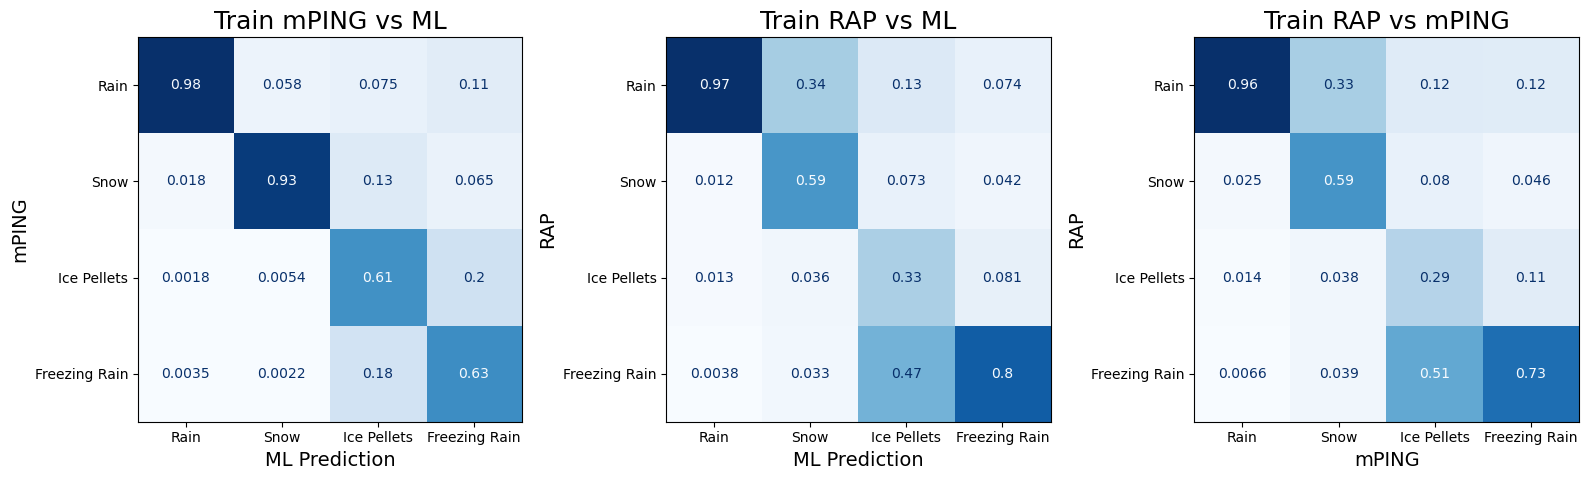

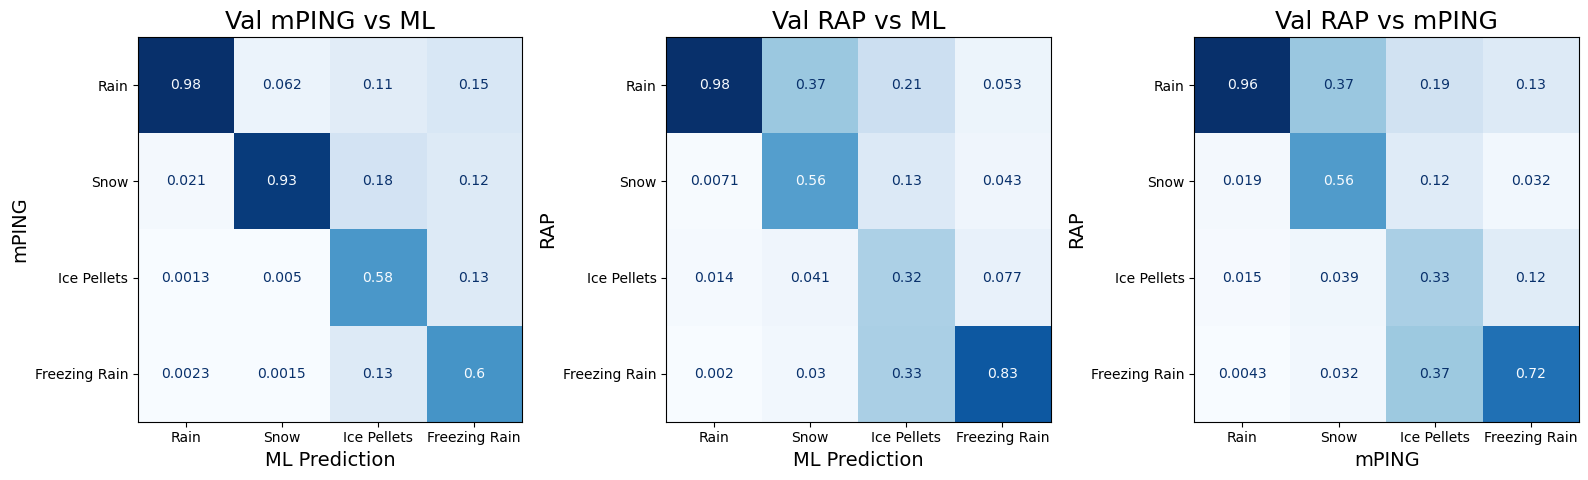

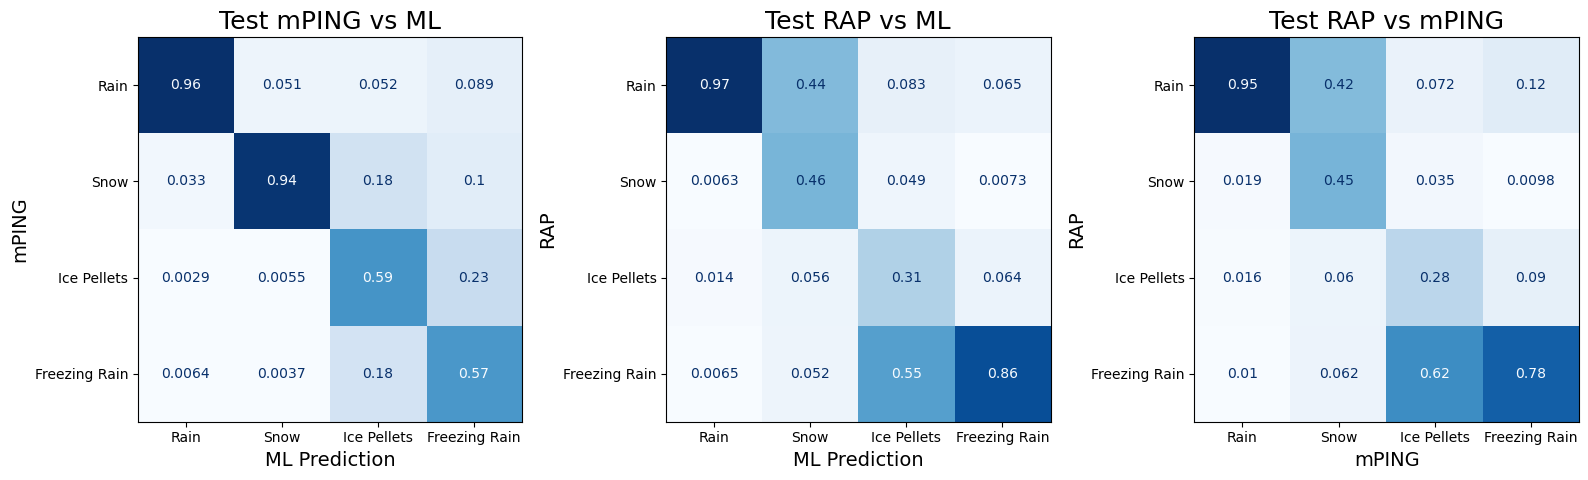

In [17]:
# Plot confusion matrices
plot_confusion_matrices(plot_data, classes, normalize='pred')

In [80]:
def plot_confusion_matrices(data, classes, figsize=(16, 6), normalize='pred'):
    """
    Function to plot confusion matrices using sns.heatmap for train, val, and test datasets.

    data: dictionary, generally has 'train', 'val', and 'test' data
    classes: different p-types to be tested, list
    normalize: normalization mode for confusion matrix, e.g., 'true', 'pred', 'all'
    figsize: size of the plot
    """
    cmap = plt.cm.Blues
    
    # Plot confusion matrices for each dataset (train, val, test)
    for i, (key, ds) in enumerate(data.items()):
        fig, axes = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)
        
        # mPING vs ML Prediction
        cm_mping = confusion_matrix(ds['true_label'], ds['pred_label'], normalize=normalize)
        sns.heatmap(cm_mping, annot=True, fmt='.2f', cmap=cmap, cbar=False,
                    xticklabels=classes, yticklabels=classes, ax=axes[0],
                    annot_kws={'size': 14})
        axes[0].set_title(f'{key.title()} mPING vs ML', fontsize=18)
        axes[0].set_ylabel('mPING', fontsize=14)
        axes[0].set_xlabel('ML Prediction', fontsize=14)
        
        # RAP vs ML Prediction
        cm_rap = confusion_matrix(ds['rap_truth'][ds['rap_precip_mask']], ds['pred_label'][ds['rap_precip_mask']], normalize=normalize)
        sns.heatmap(cm_rap, annot=True, fmt='.2f', cmap=cmap, cbar=False,
                    xticklabels=classes, yticklabels=classes, ax=axes[1],
                    annot_kws={'size': 14})
        axes[1].set_title(f'{key.title()} RAP vs ML', fontsize=18)
        axes[1].set_ylabel('RAP', fontsize=14)
        axes[1].set_xlabel('ML Prediction', fontsize=14)
        
        # RAP vs mPING
        cm_rap_mping = confusion_matrix(ds['rap_truth'][ds['rap_precip_mask']], ds['true_label'][ds['rap_precip_mask']], normalize=normalize)
        sns.heatmap(cm_rap_mping, annot=True, fmt='.2f', cmap=cmap, cbar=False,
                    xticklabels=classes, yticklabels=classes, ax=axes[2],
                    annot_kws={'size': 14})
        axes[2].set_title(f'{key.title()} RAP vs mPING', fontsize=18)
        axes[2].set_ylabel('RAP', fontsize=14)
        axes[2].set_xlabel('mPING', fontsize=14)

        #plt.suptitle(f'Confusion Matrices for {key.title()} Data', fontsize=20)
        plt.savefig(f'./plots/{key.title()}_confusion.png', dpi=200)

/glade/derecho/scratch/sreiner/tmp/ipykernel_41299/367261352.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/glade/derecho/scratch/sreiner/tmp/ipykernel_41299/367261352.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/glade/derecho/scratch/sreiner/tmp/ipykernel_41299/367261352.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


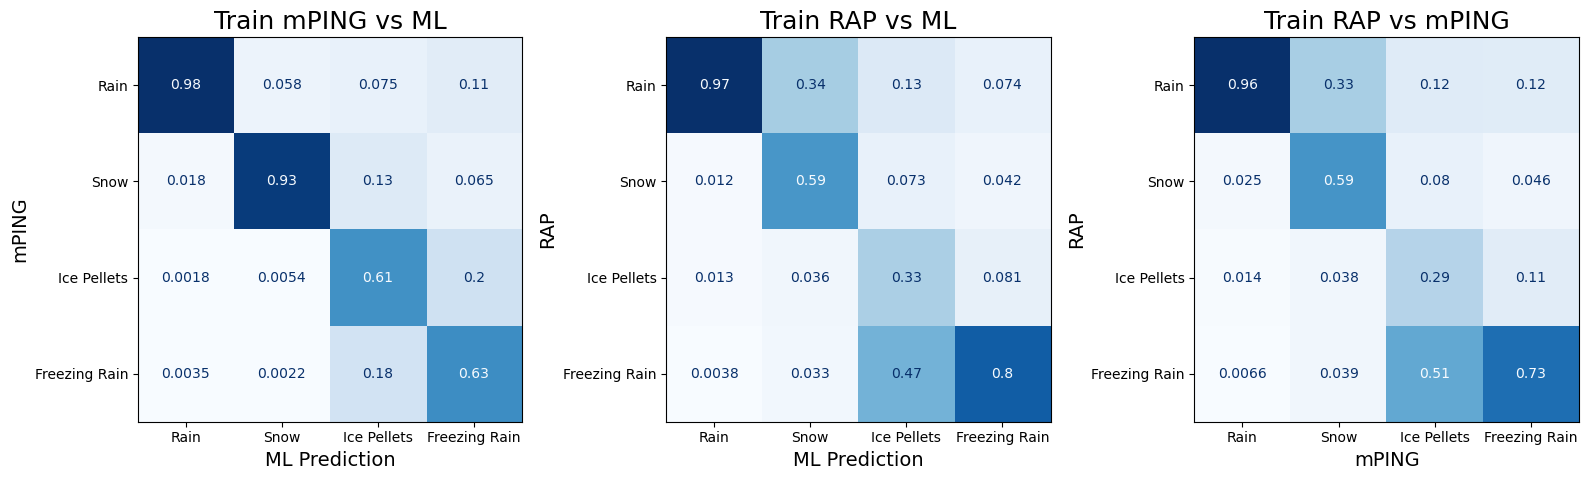

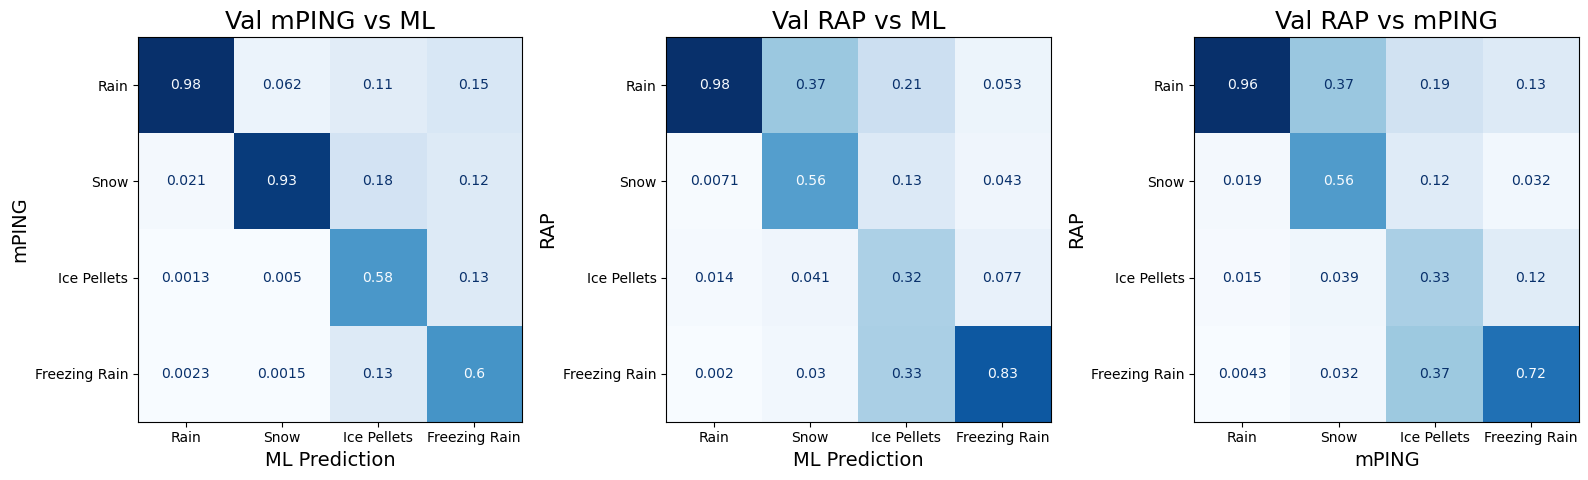

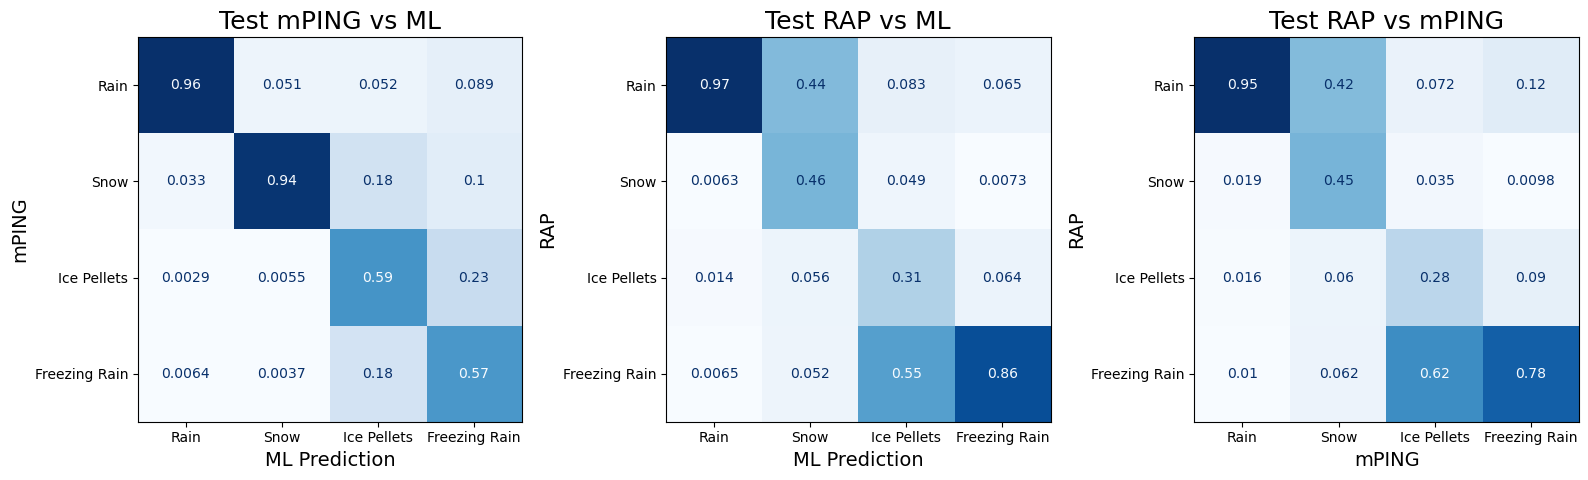

In [18]:
plot_confusion_matrices(plot_data, classes, normalize='pred')